# Twin Delated DDPG  (TD3) with PyTorch

In this notebook we will look at Twin Delayed Deep Deterministic Policy Gradient (TD3) algorithm using PyTorch. It builds on what we saw in `9.a_ddpg.ipynb` for DDPG. 

Click here to access the paper which proposed TD3: https://arxiv.org/pdf/1802.09477.pdf

TD3 is an improvement over DDPG with following changes:

1) "Twin" - Uses clipped double Q-learning. TD3 learns two q-functions ("twin") and uses smaller of the two to computer bellman errors `q_target = min(q1_target, q2_target)`

2) "Delayed" - policy updates are done at a frequency slower than Q-updates. Usually policy is updated every 2 steps of q-update.

3) Target Policy smoothing - TD3 adds noise to target actions 


The basic premise is same as DDPG. TD3 is a variation of DDPG which in turn is a variation of Q-Learning with continuous action functions. When we have discrete functions, we learn Q-function for a given state and all possible actions. We then pick the best action and Q-value using `max` over all values: Q(s,a), a is all possible actions. 

$$a^*(s) = arg \underset{a}{max} Q^*(s,a)$$ 

However, when action is continuous, we cannot find the max so easily. It becomes an optimization problem with significant costs as we have to find the max at every step.

In TD3 we learn three networks, one is a policy network which takes state as input and learns to output the policy/action. Other two networks learn the Q function. However, unlike Q-learning of past, it takes state and actions as inputs and produces Q-value as output. 

TD# is also an off-policy. Like DDPG we use ReplayBuffer to collect the transitions and iterate over a batch to do gradient update for the policy(Actor) and Q-value(Critic) networks. 

Like Q-Learning, we also use target networks, both for policy as well as Q-value. The target networks are updated using polyak averaging. The complete Algorithm is as given below:

***
**Twin Delayed DDPG (TD3)**
***
 
1. Input initial policy parameters $\theta$,  Q-function parameters $\phi_1$ and $\phi_2$, empty replay buffer D

2. Set target parameters equal to online parameters $\theta_{targ} \leftarrow \theta$, $\phi_{targ,1} \leftarrow \phi_1$ and $\phi_{targ,2} \leftarrow \phi_2$

3. **repeat**

4. Observe state $s$ and select action $a = clip(\mu_\theta(s)+\alpha \cdot \epsilon, a_{Low}, a_{High})$,<br/> 
   $\text{where } \epsilon \sim N$, and $\alpha$ is the scale of noise equal to range of action values.

5. Execute $a$ in environment and observe next state $s'$, reward $r$, and done signal $d$

6. Store $(s,a,r,s',d)$ in Replay Buffer D

7. if $s'$ is terminal state, reset the environment

8. if it's time to update **then**:

9. &emsp;&emsp;for j in range (as many updates as required):

10. &emsp;&emsp;&emsp;&emsp;Sample a batch $B={(s,a,r,s',d)}$ from replay Buffer D:

11. &emsp;&emsp;&emsp;&emsp;Compute target actions:

$$a'(s') = \text{clip}\left(\mu_{\theta_{\text{targ}}}(s') + \text{clip}(\alpha \cdot \epsilon,-c,c), a_{Low}, a_{High}\right), \;\;\;\;\; \epsilon \sim \mathcal{N}(0, \sigma)$$

12. &emsp;&emsp;&emsp;&emsp;Compute action targets: 

$$y(r,s',d) = r + \gamma (1-d) \min_{i=1,2} Q_{\phi_{\text{targ},i}}(s', a'(s'))$$

13. &emsp;&emsp;&emsp;&emsp;Update Q function with one step gradient descent on $\phi$: 
$$\nabla_\phi \frac{1}{|B|} \sum_{(s,a,r,s',d)\in B}(Q_{\phi_i}(s,a) - y(r,s',d))^2, \;\;\;\;\;  \text{for } i=1,2$$

14. &emsp;&emsp;&emsp;&emsp;if `j mod policy_update == 0`:

15. &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;Update Policy with one step gradient Ascent on $\theta$: 

$$\nabla_\theta \frac{1}{|B|} \sum_{s \in B} Q_{\phi_1}(s, \mu_\theta(s))$$

16. &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;Update target networks using polyak averaging: 
$$\phi_{targ,i} \leftarrow \rho\phi_{targ,i} + (1-\rho)\phi_i, \;\;\;\;\;  \text{for } i=1,2$$ 
$$\theta_{targ} \leftarrow \rho\theta_{targ} + (1-\rho)\theta$$
***


#### Key Features of TD3
Similar to DDPG:
1. TD3 is an off-policy algorithm.
2. TD3 can only be used for environments with continuous action spaces.
3. TD3 can be thought of as being deep Q-learning for continuous action spaces.



#### Our Implementation
THis notebook follows the code found in OpenAI's [Spinning Up Library](https://spinningup.openai.com/en/latest/algorithms/td3.html). In this notebook we have broken the code into separate code cells with required explanations. Also some of the implementations like ReplayBuffer have been borrowed from our past notebooks to provide continuity. Further some codes like building of networks have been simplified resulting in easier to understand but more verbose code. 

#### Running in Colab/Kaggle

If you are running this on Colab, please uncomment below cells and run this to install required dependencies.

In [ ]:
## Uncomment and execute this cell to install all the the dependencies if running in Google Colab

# !apt-get update && apt-get install swig cmake ffmpeg freeglut3-dev xvfb
# !pip install box2d-py
# !pip install "stable-baselines3[extra]>=2.1"
# !pip install "huggingface_sb3>=3.0"

# !pip install git+https://github.com/DLR-RM/rl-baselines3-zoo@update/hf
# !git clone https://github.com/DLR-RM/rl-baselines3-zoo
# %cd rl-baselines3-zoo/
# !pip install -r requirements.txt
# %cd ..


#### Imports

In [1]:
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
import itertools

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

from copy import deepcopy
import gymnasium as gym

from scipy.signal import convolve, gaussian
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv

from IPython.display import HTML, clear_output
from base64 import b64encode

%matplotlib inline

2024-01-25 10:47:24.860519: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-25 10:47:24.863659: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-25 10:47:24.908755: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-25 10:47:24.908809: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-25 10:47:24.908831: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

### Environment - Pendulum

We can use the setup here to run on any environment which has state as a single vector and actions are continuous. We will build it on `Pendulum-v1`.

In [2]:
def make_env(env_name):
    env = gym.make(env_name, render_mode="rgb_array")
    return env

State shape: (3,)
Action shape: (1,)


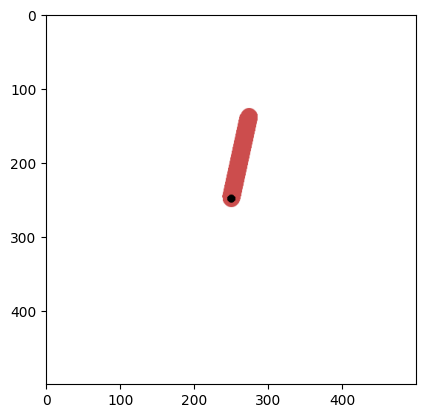

In [3]:
env_name = 'Pendulum-v1'
#env_name = 'MountainCarContinuous-v0'

env = make_env(env_name)
env.reset()
plt.imshow(env.render())
state_shape, action_shape = env.observation_space.shape, env.action_space.shape
print('State shape: {}'.format(state_shape))
print('Action shape: {}'.format(action_shape))
env.close()

### Build Policy network (Actor)
It is a simple 2 hidden layer network which takes state as input and produces action making sure that action values are within the allowed range.

In [4]:
class MLPActor(nn.Module):
    def __init__(self, state_dim, act_dim, act_limit):
        super().__init__()
        self.act_limit = act_limit
        self.fc1 = nn.Linear(state_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.actor = nn.Linear(256, act_dim)
    
    def forward(self, s):
        x = self.fc1(s)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.actor(x)
        x = torch.tanh(x)  # to output in range(-1,1)
        x = self.act_limit * x
        return x

### Build Q-network network (Critic)
It is a simple 2 hidden layer network which takes state and action as input and produces Q-value as output. We will have two versions of Q-network as Critic

In [5]:
class MLPQFunction(nn.Module):
    def __init__(self, state_dim, act_dim):
        super().__init__()
        self.fc1 = nn.Linear(state_dim+act_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.Q = nn.Linear(256, 1)
    
    def forward(self, s, a):
        x = torch.cat([s,a], dim=-1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        q = self.Q(x)
        return q
        

### Combine Actor and Critic into a single model

One policy Network and Two Q-networks as discussed above:

In [6]:
class MLPActorCritic(nn.Module):
    def __init__(self, observation_space, action_space):
        super().__init__()
        self.state_dim = observation_space.shape[0]
        self.act_dim = action_space.shape[0]
        self.act_limit = action_space.high[0]
        
        #build Q and policy functions
        self.q1 = MLPQFunction(self.state_dim, self.act_dim)
        self.q2 = MLPQFunction(self.state_dim, self.act_dim)
        self.policy = MLPActor(self.state_dim, self.act_dim, self.act_limit)
        
    def act(self, state):
        with torch.no_grad():
            return self.policy(state).numpy()

    def get_action(self, s, noise_scale):
        a = self.act(torch.as_tensor(s, dtype=torch.float32))
        a += noise_scale * self.act_limit * np.random.randn(self.act_dim)
        return np.clip(a, -self.act_limit, self.act_limit)
        

### Experience replay

We will use the replay buffer we saw in chapter 4 listings. Replay buffer is very important in DQN to break the correlation between samples. We use a behavior policy ($\epsilon-greedy$) to sample from the environment and store the transitions (s,a,r,s',done) into a buffer. These samples are used multiple times in a learning making the process sample efficient. 

The interface to ReplayBuffer is:
* `exp_replay.add(state, action, reward, next_state, done)` - saves (s,a,r,s',done) tuple into the buffer
* `exp_replay.sample(batch_size)` - returns states, actions, rewards, next_states and done_flags for `batch_size` random samples.
* `len(exp_replay)` - returns number of elements stored in replay buffer.



In [7]:
class ReplayBuffer:
    def __init__(self, size=1e6):
        self.size = size #max number of items in buffer
        self.buffer =[] #array to holde buffer
        self.next_id = 0
    
    def __len__(self):
        return len(self.buffer)
    
    def add(self, state, action, reward, next_state, done):
        item = (state, action, reward, next_state, done)
        if len(self.buffer) < self.size:
            self.buffer.append(item)
        else:
            self.buffer[self.next_id] = item
        self.next_id = (self.next_id + 1) % self.size
        
    def sample(self, batch_size=32):
        idxs = np.random.choice(len(self.buffer), batch_size)
        samples = [self.buffer[i] for i in idxs]
        states, actions, rewards, next_states, done_flags = list(zip(*samples))
        return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(done_flags)
    

### Q-loss

Compute Q-loss as per equations:

$$a'(s') = \text{clip}\left(\mu_{\theta_{\text{targ}}}(s') + \text{clip}(\epsilon,-c,c), a_{Low}, a_{High}\right), \;\;\;\;\; \epsilon \sim \mathcal{N}(0, \sigma)$$

$$y(r,s',d) = r + \gamma (1-d) \min_{i=1,2} Q_{\phi_{\text{targ},i}}(s', a'(s'))$$

 
$$Q_{Loss, i} = \frac{1}{|B|} \sum_{(s,a,r,s',d)\in B}(Q_{\phi_i}(s,a) - y(r,s',d))^2, \;\;\;\;\;$$

$$Q_{Loss} = \sum_{i=1,2} Q_{Loss, i}$$
    
    
    

In [8]:
def compute_q_loss(agent, target_network, states, actions, rewards, next_states, done_flags,
                    gamma, target_noise, noise_clip, act_limit):
    
    # convert numpy array to torch tensors
    states = torch.tensor(states, dtype=torch.float)
    actions = torch.tensor(actions, dtype=torch.float)
    rewards = torch.tensor(rewards, dtype=torch.float)[:,None]
    next_states = torch.tensor(next_states, dtype=torch.float)
    done_flags = torch.tensor(done_flags.astype('float32'),dtype=torch.float)[:,None]
    
    # get q-values for all actions in current states
    # use agent network
    q1 = agent.q1(states, actions)
    q2 = agent.q2(states, actions)
    
    # Bellman backup for Q function
    with torch.no_grad():
        
        action_target = target_network.policy(next_states)
        
        # Target policy smoothing
        epsilon = torch.randn_like(action_target) * target_noise * act_limit
        epsilon = torch.clamp(epsilon, -noise_clip, noise_clip)
        action_target = action_target + epsilon
        action_target = torch.clamp(action_target, -act_limit, act_limit)
            
            
        q1_target = target_network.q1(next_states, action_target)
        q2_target = target_network.q2(next_states, action_target)
        q_target = torch.min(q1_target, q2_target) 
        target = rewards + gamma * (1 - done_flags) * q_target

    # MSE loss against Bellman backup
    loss_q1 = F.mse_loss(q1, target)
    loss_q2 = F.mse_loss(q2, target)
    loss_q = loss_q1+loss_q2
    
    return loss_q

### Policy-Loss

Compute Policy Loss as per equation:
    
$$Policy_{Loss} = - \frac{1}{|B|} \sum_{s \in B} Q_{\phi_1}(s,  \mu_\theta (s))$$


Please note the `-` sign. We need to do gradient ascent but PyTorch does gradient descent. We convert the ascent to descent using a -ve sign. 

In [9]:
def compute_policy_loss(agent, states):
    
    # convert numpy array to torch tensors
    states = torch.tensor(states, dtype=torch.float)
    
    q1_values = agent.q1(states, agent.policy(states))
    
    loss_policy = - q1_values.mean()
    
    return loss_policy

### One step gradient Descent on both Policy(Actor) and Q-value(Critic)

The policy update is delayed. It is updated every `policy_delay` updates of Q updates.

In [10]:
def one_step_update(agent, target_network, q_optimizer, policy_optimizer, 
                    states, actions, rewards, next_states, done_flags, step, update_every,
                    gamma, polyak, target_noise, noise_clip, act_limit):
    
    #one step gradient for q-values
    loss_q = compute_q_loss(agent, target_network, states, actions, rewards, next_states, done_flags,
                    gamma, target_noise, noise_clip, act_limit)
    q_optimizer.zero_grad()
    loss_q.backward()
    q_optimizer.step()

    loss_policy_ret = None
    # Update policy and all target networks after `update_every` gradient steps of Q-networks
    if step % update_every == 0:
        #one step gradient for policy network
        loss_policy = compute_policy_loss(agent, states)
        policy_optimizer.zero_grad()
        loss_policy.backward()
        policy_optimizer.step()
        loss_policy_ret = loss_policy.item()

        # update target networks with polyak averaging
        for params, params_target in zip(agent.parameters(), target_network.parameters()):
            params_target.data.mul_(polyak)
            params_target.data.add_((1-polyak)*params.data)

    return loss_q.item(), loss_policy_ret

### To Test performance of agent without any noise

In [11]:
def test_agent(env, agent, num_test_episodes, seed=42):
    ep_rets, ep_lens = [], []
    for j in range(num_test_episodes):
        state, _ = env.reset(seed=seed)
        done, ep_ret, ep_len = False, 0, 0
        while not done:
            # Take deterministic actions at test time (noise_scale=0)
            state, reward, terminated, truncated, _ = env.step(agent.get_action(state, 0))
            ep_ret += reward
            ep_len += 1
            done = terminated or truncated
        ep_rets.append(ep_ret)
        ep_lens.append(ep_len)
    return np.mean(ep_rets), np.mean(ep_lens)

### Utility Functions

In [12]:
def smoothen(values):
    kernel = gaussian(100, std=100)
    kernel = kernel / np.sum(kernel)
    return convolve(values, kernel, 'valid')

### TD3 Algorithm

We pull all the pieces together to train the agent

In [13]:
def td3(env_fn, seed=5, 
         total_steps=20000, replay_size=20000, gamma=0.98, 
         polyak=0.995, policy_lr=0.001, q_lr=0.001, batch_size=256, start_steps=10000, 
         update_every=2, act_noise=0.1, target_noise=0.2,
         noise_clip=0.5, num_test_episodes=3, eval_freq=500):
    
    torch.manual_seed(seed)
    np.random.seed(seed)
    env, test_env = env_fn(), env_fn()
    loss_q_history, loss_policy_history, return_history, length_history = [], [], [], []
    state_dim = env.observation_space.shape
    act_dim = env.action_space.shape[0]
    act_limit = env.action_space.high[0]
    
    agent = MLPActorCritic(env.observation_space, env.action_space)
    target_network = deepcopy(agent)
    
    # Experience buffer
    replay_buffer = ReplayBuffer(replay_size)
    
    # List of parameters for both Q-networks 
    q_params = itertools.chain(agent.q1.parameters(), agent.q2.parameters())

    #optimizers
    q_optimizer = Adam(q_params, lr=q_lr)
    policy_optimizer = Adam(agent.policy.parameters(), lr=policy_lr)
    
    state, _ = env.reset()
    
    for t in range(total_steps):
        if t >= start_steps:
            with torch.no_grad():
                action = agent.get_action(state, act_noise)
        else:
            action = env.action_space.sample()
            
        next_state, reward, terminated, truncated, _ = env.step(action)
        # some environments do not terminate and therefore we get
        # truncated signal from env
        # we will use both terminated or truncated to reset the game
        # so that agent can learn from all phases including starting phases
        # however for Q target calculation will use only terminated as truncated
        # is just a termination due to max time limit and not end of game
        done = terminated
                
        # Store experience to replay buffer
        replay_buffer.add(state, action, reward, next_state, done)
        
        # dont ever forget this step :)
        state = next_state
        
        # End of trajectory handling
        if terminated or truncated:
            state, _ = env.reset(seed=seed+t)

        # Update handling
        if t >= start_steps:
        # if t >= start_steps and t % update_every == 0:
                states, actions, rewards, next_states, done_flags = replay_buffer.sample(batch_size)
                
                loss_q, loss_policy = one_step_update(
                        agent, target_network, q_optimizer, policy_optimizer, 
                        states, actions, rewards, next_states, done_flags,
                        t, update_every, gamma, polyak, target_noise, noise_clip, act_limit
                )
        
                loss_q_history.append(loss_q)
                if loss_policy:
                    loss_policy_history.append(loss_policy)

        # End of epoch handling
        if t >= start_steps and t % eval_freq == 0:
            avg_ret, avg_len = test_agent(test_env, agent, num_test_episodes)
            return_history.append(avg_ret)
            length_history.append(avg_len)

            clear_output(True)
            print(f'Steps:{t+1},loss:{loss_q:0.3f},{loss_policy:0.3f}, mean return:{avg_ret}, mean length:{avg_len}')
            plt.figure(figsize=[16, 5])
            plt.subplot(1, 3, 1)
            plt.title("Mean return per episode")
            plt.plot(return_history)
            plt.grid()

            plt.subplot(1, 3, 2)
            plt.title("Loss(Q)")
            plt.plot(smoothen(loss_q_history))
            plt.grid()
            
            plt.subplot(1, 3, 3)
            plt.title("Loss(Actor)")
            plt.plot(smoothen(loss_policy_history))
            plt.grid()
            
            plt.show()
    
    return agent, loss_q_history, loss_policy_history, return_history, length_history

### Train the agent

Steps:19501,loss:0.578,73.065, mean return:-119.63990941940806, mean length:200.0


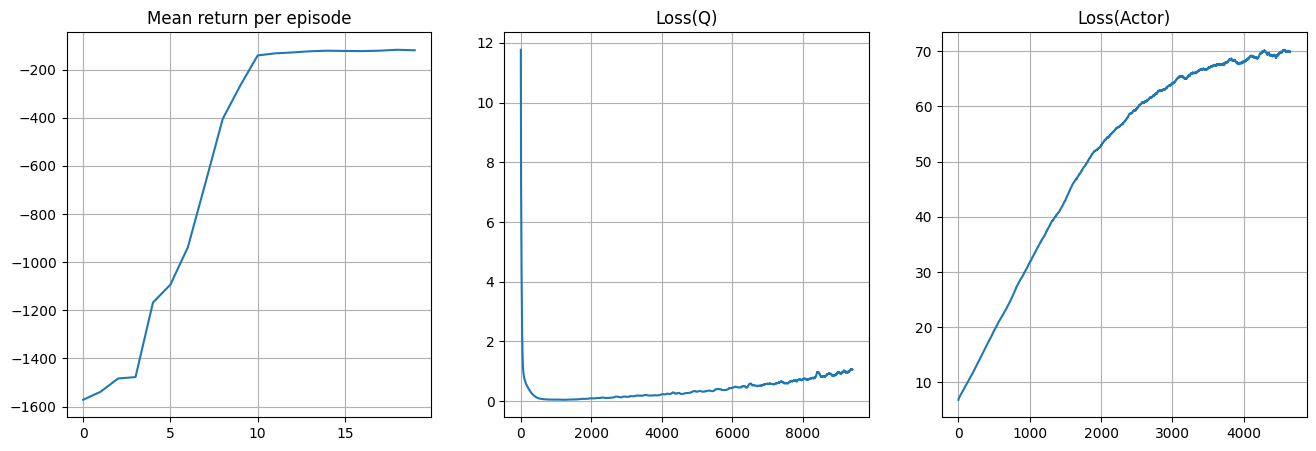

In [14]:
env_name = 'Pendulum-v1'
agent, _, _, _, _ = td3(lambda : make_env(env_name), update_every=2)

**Let us record a video of trained agent**

In [15]:
# Helper function to record videos
def record_video(env_id, video_folder, video_length, agent):

    vec_env = DummyVecEnv([lambda: gym.make(env_id, render_mode="rgb_array")])
    # Record the video starting at the first step
    vec_env = VecVideoRecorder(vec_env, video_folder,
                           record_video_trigger=lambda x: x == 0, video_length=video_length,
                           name_prefix=f"{type(agent).__name__}-{env_id}")

    obs = vec_env.reset()
    for _ in range(video_length + 1):
        action = agent.get_action(obs, 0)
        obs, _, _, _ = vec_env.step(action)
    # video filename
    file_path = "./"+video_folder+vec_env.video_recorder.path.split("/")[-1]
    # Save the video
    vec_env.close()
    return file_path

def play_video(file_path):
    mp4 = open(file_path, 'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML("""
        <video width=400 controls>
              <source src="%s" type="video/mp4">
        </video>
        """ % data_url)

In [16]:
video_folder = "logs/9_b/"
video_length = 500

video_file = record_video(env_name, video_folder, video_length, agent)

play_video(video_file)

Saving video to /home/nsanghi/sandbox/apress/drl-2ed/chapter9/logs/9_b/MLPActorCritic-Pendulum-v1-step-0-to-step-500.mp4
Moviepy - Building video /home/nsanghi/sandbox/apress/drl-2ed/chapter9/logs/9_b/MLPActorCritic-Pendulum-v1-step-0-to-step-500.mp4.
Moviepy - Writing video /home/nsanghi/sandbox/apress/drl-2ed/chapter9/logs/9_b/MLPActorCritic-Pendulum-v1-step-0-to-step-500.mp4



Moviepy - Done !
Moviepy - video ready /home/nsanghi/sandbox/apress/drl-2ed/chapter9/logs/9_b/MLPActorCritic-Pendulum-v1-step-0-to-step-500.mp4


#### Train and evaluate performance on LunarLander Environment

Steps:12501,loss:46.524,4.879, mean return:128.94192753761854, mean length:493.0


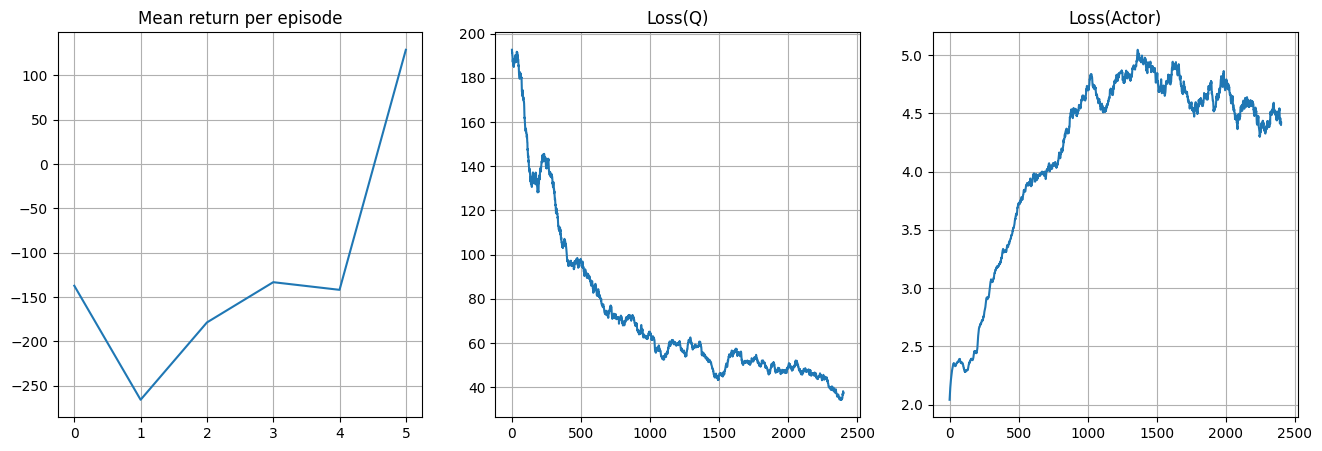

Saving video to /home/nsanghi/sandbox/apress/drl-2ed/chapter9/logs/9_b/MLPActorCritic-LunarLanderContinuous-v2-step-0-to-step-1500.mp4
Moviepy - Building video /home/nsanghi/sandbox/apress/drl-2ed/chapter9/logs/9_b/MLPActorCritic-LunarLanderContinuous-v2-step-0-to-step-1500.mp4.
Moviepy - Writing video /home/nsanghi/sandbox/apress/drl-2ed/chapter9/logs/9_b/MLPActorCritic-LunarLanderContinuous-v2-step-0-to-step-1500.mp4



Moviepy - Done !
Moviepy - video ready /home/nsanghi/sandbox/apress/drl-2ed/chapter9/logs/9_b/MLPActorCritic-LunarLanderContinuous-v2-step-0-to-step-1500.mp4


In [18]:
# Train
env_name = 'LunarLanderContinuous-v2'
agent1, _, _, _, _ = td3(lambda : make_env(env_name), policy_lr=0.0005, q_lr=0.0005, update_every=1, total_steps=13000)


# Animate learned policy
video_folder = "logs/9_b/"
video_length = 1500
video_file = record_video(env_name, video_folder, video_length, agent1)
play_video(video_file)

### Conclusion
We have trained our first code and we can see that the code is very similar to the Actor Critic algorithm that we saw in previous chapters. Using TD3 we have been able to train agents with continuous actions and quality of training is better than what we got from DDPG.
